In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/SSDFiles')

!pip install torchmetrics

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 40.2 MB/s eta 0:00:00


In [ ]:
print(torch.__version__)
print(torchvision.__version__)

NameError: name 'torch' is not defined

In [ ]:
import torchvision
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights
def create_model(num_classes=91, size=300):
    # Load the Torchvision pretrained model.
    model = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1
    )
    # Retrieve the list of input channels.
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # List containing number of anchors based on aspect ratios.
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # The classification head.
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    # Image size for transforms.
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model
if __name__ == '__main__':
    model = create_model(2, 640)
    print(model)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 190MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
!pip install python-utils

In [ ]:
#plotting images from dataset to ensure loading correctly
import random
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import albumentations as A


def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(image)
    plt.show()


def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5

    for i in range(1, len(images)):
        if bboxes is not None:
            img = visualize_bbox(images[i - 1], bboxes[i - 1], class_name="Elon")
        else:
            img = images[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()


# From https://albumentations.ai/docs/examples/example_bboxes/
def visualize_bbox(img, bbox, class_name, color=(255, 0, 0), thickness=5):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    return img

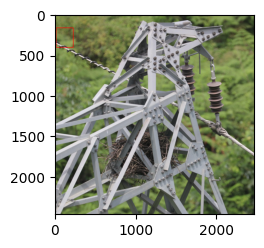

In [2]:
import os
from pickle import TRUE
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights



class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path))
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # coco format, bbox = [xmin, ymin, width, height]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)



def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model_instance_segmentation(num_classes):
    size = 300
    # Load the Torchvision pretrained model.
    model = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1
    )
    # Retrieve the list of input channels.
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # List containing number of anchors based on aspect ratios.
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # The classification head.
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    # Image size for transforms.
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model


'\nclass myOwnDataset(torch.utils.data.Dataset):\n    def __init__(self, root, annotation, transforms=None):\n        self.root = root\n        self.transforms = transforms\n        self.coco = COCO(annotation)\n        self.ids = list(sorted(self.coco.imgs.keys()))\n\n    def __getitem__(self, index):\n        # Own coco file\n        coco = self.coco\n        # Image ID\n        img_id = self.ids[index]\n        # List: get annotation id from coco\n        ann_ids = coco.getAnnIds(imgIds=img_id)\n        # Dictionary: target coco_annotation file for an image\n        coco_annotation = coco.loadAnns(ann_ids)\n        # path for input image\n        path = coco.loadImgs(img_id)[0]["file_name"]\n        # open the input image\n        img = Image.open(os.path.join(self.root, path))\n        # number of objects in the image\n        num_objs = len(coco_annotation)\n\n        # Bounding boxes for objects\n        # In coco format, bbox = [xmin, ymin, width, height]\n        # In pytorch, 

In [3]:
import csv

# Define a CSV file to store the loss values
csv_file = '/content/drive/MyDrive/SSDFiles/SSDData.csv'

# Create or open the CSV file and write the header (only once)
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Iteration', 'Training loss_classifier', 'Trainingg loss_box_reg', 'Training total_loss',
                     'Validation loss_classifier', 'Validation loss_box_reg',
                     'Training mAP', 'Training mAP50', 'Training mAP75', 'Training AR1', 'Training AR10', 'Training AR100',
                     'Training map_small', 'Training map_medium', 'Training map_large', 'Training mar_small', 'Training mar_medium', 'Training mar_large',
                     'Validation mAP', 'Validation mAP50', 'Validation mAP75', 'Validation AR1', 'Validation AR10', 'Validation AR100',
                     'Validation map_small', 'Validation map_medium', 'Validation map_large', 'Validation mar_small', 'Validation mar_medium', 'Validation mar_large',
                     'Learning Rate During Training'])


In [ ]:
#verfying the dataset creation and annotations are correct

import torchvision.transforms.functional as F
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.utils import draw_bounding_boxes
import config
from utils import (
    get_model_instance_segmentation,
    collate_fn,
    get_transform,
    myOwnDataset,
)

#id2label = {1: "nest"}
dataset = myOwnDataset(
    root=config.train_data_dir, annotation=config.train_coco, transforms=get_transform()
)
img, target = dataset[1]
print(target)
#labels = [for id in target["labels"].tolist()]

#print(labels)

img = draw_bounding_boxes(
    img, target["boxes"], colors="Turquoise", width=2
)
img = F.to_pil_image(img.detach())
img

In [ ]:
import torch
import torchvision
#import config
#from SSDutils import (
#    get_model_instance_segmentation,
#    collate_fn,
#    get_transform,
#    myOwnDataset,
#)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch.nn as nn

print("Torch version:", torch.__version__)

num_epochs = 50

train_data = '/content/drive/MyDrive/niaochao COCO/train'
train_coco = '/content/drive/MyDrive/niaochao COCO/train/_annotations.coco.json'

validation_data_dir = '/content/drive/MyDrive/niaochao COCO/valid'
validation_coco = '/content/drive/MyDrive/niaochao COCO/valid/_annotations.coco.json'

# Training dataset
my_dataset = myOwnDataset(
    root=train_data, annotation=train_coco, transforms=get_transform()
)

# own DataLoader for training dataset
data_loader = torch.utils.data.DataLoader(
    my_dataset,
    batch_size=8,
    shuffle=True,#config.train_shuffle_dl,
    num_workers=2,#work around for windows way of handling number of workers
    collate_fn=collate_fn,
)

# Validation dataset
validation_dataset = myOwnDataset(
    root=validation_data_dir, annotation=validation_coco, transforms=get_transform()
)

# own DataLoader for validation dataset
validation_data_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,#work around for windows way of handling number of workers
    collate_fn=collate_fn,
)

# select device (whether GPU or CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    #print(annotations)

# DataLoader is iterable over Dataset
for vimgs, vannotations in validation_data_loader:
    vimgs = list(img.to(device) for img in vimgs)
    vannotations = [{k: v.to(device) for k, v in t.items()} for t in vannotations]

model = get_model_instance_segmentation(2)#input parameter for the number of classes

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
#optimizer = torch.optim.SGD(params, lr=0.002, weight_decay=0.0001, momentum=0.9, nesterov=True)
scheduler = StepLR(optimizer=optimizer,step_size=10,gamma=0.5,verbose=True)

len_dataloader = len(data_loader)
len_vdataloader = len(data_loader)

#mAP metrics
metric_map = MeanAveragePrecision()
metric_mapVal = MeanAveragePrecision()

accuracy = 0.0
print("Model Details:")
print(model)

# Training
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}/{num_epochs}")
    model.train()
    i = 0
    metric_map.reset()
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)#returns multiple different types of losses from the faster RCNN model
        losses = sum(loss for loss in loss_dict.values())

        # Extract individual loss values
        loss_classifier = loss_dict['classification'].item()
        loss_box_reg = loss_dict['bbox_regression'].item()

        # Display each loss from the loss_dict
        #for loss_name, loss_value in loss_dict.items():
          #print(f"{loss_name}: {loss_value.item()}")

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr = optimizer.param_groups[0]['lr']
    model.eval()
    with torch.no_grad():
        predictionsT = model(imgs)
        metric_map.update(predictionsT, annotations)

    map_metric = metric_map.compute()
    print("Training Metrics:")
    print(map_metric)

    print(f"Iteration: {i}/{len_dataloader}, Loss: {losses}")

#############################################################################################################

    total_classification_loss = 0.0
    total_box_regression_loss = 0.0
    num_batches = 0
    classification_loss_fn = nn.CrossEntropyLoss()
    box_regression_loss_fn = nn.SmoothL1Loss()
    #print(annotations)
    #validation after each epoch
    print("Validation on Validation Set:\n")
    model.eval()
    metric_mapVal.reset()
    with torch.no_grad():
      for vimgs, vannotations in validation_data_loader:
        vimgs = list(img.to(device) for img in vimgs)
        vannotations = [{k: v.to(device) for k, v in t.items()} for t in vannotations]


        model.train()
        vloss_dict = model(vimgs, vannotations)
        vlosses = sum(loss for loss in vloss_dict.values())

        # Extract individual loss values
        vloss_classifier = vloss_dict['classification'].item()
        vloss_box_reg = vloss_dict['bbox_regression'].item()
        model.eval()

        #allBoxes = []
        #allLabels = []

        predictionsV = model(vimgs)
        metric_mapVal.update(predictionsV, vannotations)
       # highConfidence = []
        #highConfidence = predictionsV['scores']>0.5
        #i = 0
        #for a in vannotations:
         #   box = a['boxes'][i]
         #   labels = a['labels'][i]
         #   allBoxes.append(box)
        #    allLabels.append(labels)
         #   i = i +1


      map_metricVal = metric_mapVal.compute()
      print(map_metricVal)


      if(map_metricVal['map'].item()>accuracy):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDBestWeights.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDModelBestWeights.pt')
        accuracy = map_metricVal['map'].item()

      if(epoch ==  9):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch10.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch10.pt')

      if(epoch ==  19):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch20.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch20.pt')

      if(epoch ==  29):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch30.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch30.pt')

      if(epoch ==  39):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch40.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch40.pt')

      if(epoch ==  49):
        torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch50.pth')
        torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch50.pt')


      #print(f"Iteration: {i}/{len_vdataloader}, Val Loss: {vlosses}")
      with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, i, loss_classifier, loss_box_reg, losses, vloss_classifier, vloss_box_reg,
                         map_metric['map'].item(), map_metric['map_50'].item(), map_metric['map_75'].item(), map_metric['mar_1'].item(), map_metric['mar_10'].item(), map_metric['mar_100'].item(),
                         map_metric['map_small'].item(), map_metric['map_medium'].item(), map_metric['map_large'].item(), map_metric['mar_small'].item(), map_metric['mar_medium'].item(), map_metric['mar_large'].item(),
                         map_metricVal['map'].item(), map_metricVal['map_50'].item(), map_metricVal['map_75'].item(), map_metricVal['mar_1'].item(), map_metricVal['mar_10'].item(), map_metricVal['mar_100'].item(),
                         map_metricVal['map_small'].item(), map_metricVal['map_medium'].item(), map_metricVal['map_large'].item(), map_metricVal['mar_small'].item(), map_metricVal['mar_medium'].item(), map_metricVal['mar_large'].item(),
                         lr])
    scheduler.step()


Torch version: 2.4.1+cu121
loading annotations into memory...
Done (t=3.67s)
creating index...
index created!
loading annotations into memory...
Done (t=1.47s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:07<00:00, 18.8MB/s]


Model Details:
SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

{'bbox_regression': tensor(1.2616, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(2.5834, device='cuda:0', grad_fn=<DivBackward0>)}


13
13
100
13


{'bbox_regression': tensor(2.9153, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(13.8617, device='cuda:0', grad_fn=<DivBackward0>)}


NameError: name 'model' is not defined

In [ ]:
#testing one image on model to ensure working
import torch
import torchvision
from torchvision import transforms as T

from PIL import Image#reading images
import cv2
from google.colab.patches import cv2_imshow


#ig = Image.open('/content/drive/MyDrive/niaochao COCO/test/100042_jpg.rf.28a618c076bfe7a8e2f6c1f0cb038904.jpg')
ig=Image.open('/content/drive/MyDrive/niaochao COCO/test/100248_jpg.rf.e1fa97c975fc67ea8d438e61fbbae692.jpg')

In [ ]:

transformqw = T.Compose([T.ToTensor()])
img = transformqw(ig)
img = img.to(device)#fixed the issue

with torch.no_grad():
  pred = model([img])

pred

[{'boxes': tensor([[5.0544e+02, 1.3470e+03, 1.6498e+03, 2.0675e+03],
          [2.3964e+03, 0.0000e+00, 2.4660e+03, 8.5018e+01],
          [4.2619e-01, 2.4278e+03, 9.1421e+01, 2.4650e+03],
          [0.0000e+00, 0.0000e+00, 1.4566e+02, 1.5160e+02],
          [4.0904e+02, 2.3632e+03, 7.0479e+02, 2.4650e+03],
          [2.0102e+03, 9.6378e+02, 2.1173e+03, 1.0838e+03],
          [2.3513e+03, 0.0000e+00, 2.4660e+03, 1.5691e+02],
          [2.3537e+03, 2.3471e+03, 2.4660e+03, 2.4650e+03],
          [1.9176e+03, 8.4676e+02, 2.0625e+03, 1.1160e+03],
          [0.0000e+00, 4.4493e+02, 1.1538e+02, 5.3366e+02],
          [0.0000e+00, 0.0000e+00, 9.7889e+01, 6.6250e+01],
          [0.0000e+00, 2.3554e+03, 1.5345e+02, 2.4650e+03],
          [2.2211e+03, 0.0000e+00, 2.3437e+03, 9.8922e+01],
          [2.2616e+03, 0.0000e+00, 2.4153e+03, 1.1721e+02],
          [0.0000e+00, 1.4096e+03, 4.3822e+02, 2.4650e+03],
          [2.0254e+03, 1.6874e+01, 2.1368e+03, 9.4380e+01],
          [2.4270e+03, 2.4260e+

In [ ]:
bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
num = torch.argwhere(scores > 0.3).shape[0]#get where scores greater than 90%
num = 5
bboxes = bboxes.cpu()
igg=cv2.imread('/content/drive/MyDrive/niaochao COCO/test/100042_jpg.rf.28a618c076bfe7a8e2f6c1f0cb038904.jpg')
font=cv2.FONT_HERSHEY_SIMPLEX
for i in range(num):
  x1, y1, x2, y2 = bboxes[i].numpy().astype("int")
  #print(x1, y1, x2, y2)
  #class_name = "nest"#mapping to class names
  igg = cv2.rectangle(igg,(x1,y1),(x2,y2),(0,255,0),1)
  #igg = cv2.putText(igg, class_name, (x1,y1-10),font,0.5,(255,0,0),1,cv2.LINE_AA)

In [ ]:
cv2_imshow(igg)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#saving models
torch.save(model.state_dict(),'/content/drive/MyDrive/SSDFiles/SSDEpoch27Batch8.pth')
torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch27Batch8.pt')

In [ ]:
torch.save(model,'/content/drive/MyDrive/SSDFiles/SSDEpoch27Batch8.pt')